In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from glob import glob
from tqdm import tqdm
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

train_val_df = pd.read_csv("../../data/train_val.csv")
test_df = pd.read_csv("../../data/test.csv")

# Extract the paths and labels
disease_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'No Finding']
train_val_labels = train_val_df[disease_labels].values
test_labels = test_df[disease_labels].values

In [2]:
train_val_df['Paths'] = train_val_df['Paths'].apply(lambda x : x.split("../../../")[1])
test_df['Paths'] = test_df['Paths'].apply(lambda x : x.split("../../../")[1])

## random sample

In [3]:
len(train_val_df)

86523

In [4]:
# import random

# train_val_df = train_val_df.sample(frac=0.1, replace=True, random_state=1)
# test_df = test_df.sample(frac=0.1, replace=True, random_state=1)

# print("train_val_df length : ", len(train_val_df))
# print("test_df length : ", len(test_df))

In [5]:
# class CustomDataset(Dataset):
#     def __init__(self, dataframe, labels, transform=None):
#         self.dataframe = dataframe
#         self.labels = labels
#         self.transform = transform

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):
#         img_name = os.path.join(self.dataframe.iloc[idx]['Paths'])
#         image = Image.open(img_name).convert('RGB')
#         label = self.labels[idx]

#         if self.transform:
#             image = self.transform(image)

#         return image, torch.tensor(label, dtype=torch.float32)

# from torchvision import transforms

# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
# ])

# train_val_dataset = CustomDataset(train_val_df, train_val_labels, transform=transform)
# test_dataset = CustomDataset(test_df, test_labels, transform=transform)

# train_loader = DataLoader(train_val_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [6]:
# import torch.nn as nn
# import torchvision.models as models

# class ResNetModified(nn.Module):
#     def __init__(self):
#         super(ResNetModified, self).__init__()
#         original_model = models.resnet50(pretrained=True)
#         self.features = nn.Sequential(*list(original_model.children())[:-1])
#         self.fc = nn.Sequential(
#             nn.Linear(2048, 1024),
#             nn.ReLU(),
#             nn.Linear(1024, 15),
#             nn.Sigmoid()  # Sigmoid for multi-label classification
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         return x

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = ResNetModified()

# model = nn.DataParallel(model)
# model = model.to(device)


In [7]:
# # 20시간 걸림 (1207m)

# criterion = nn.BCELoss()  # Binary Cross Entropy Loss
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# num_epochs = 20

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for images, labels in tqdm(train_loader, desc=f"Train_loader Epoch: {epoch}"):
#         images, labels = images.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

#     # Evaluate the model
#     model.eval()
#     all_labels = []
#     all_outputs = []
#     with torch.no_grad():
#         for images, labels in tqdm(test_loader, desc=f"Test_loader Epoch: {epoch}"):
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             all_labels.append(labels.cpu().numpy())
#             all_outputs.append(outputs.cpu().numpy())

#     all_labels = np.vstack(all_labels)
#     all_outputs = np.vstack(all_outputs)
#     all_outputs = (all_outputs > 0.5).astype(int)

#     accuracy = accuracy_score(all_labels, all_outputs)
#     roc_auc = roc_auc_score(all_labels, all_outputs)
#     f1 = f1_score(all_labels, all_outputs, average='micro')

#     print(f"Accuracy: {accuracy}, F1-Score: {f1}, Roc_Auc: {roc_auc}")


# root_save_path = "save"
# if not os.path.exists(root_save_path):
#     os.makedirs(root_save_path)
    
# model_save_path =os.path.join(root_save_path, "resnet_modified_bs64.pth")

# # Save the model
# torch.save(model.state_dict(), model_save_path)


In [8]:
# model_weight_path = torch.load("save/resnet_modified_bs64.pth")
# model.load_state_dict(model_weight_path)

In [9]:
# # 20분 걸림 (20m)
# def evaluate_and_save_results(model, test_loader, threshold=0.5):
#     model.eval()
#     all_labels = []
#     all_outputs = []
#     all_filenames = []

#     with torch.no_grad():
#         for images, labels in tqdm(test_loader, desc="Test Loader"):
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             all_labels.append(labels.cpu().numpy())
#             all_outputs.append(outputs.cpu().numpy())
#             all_filenames.extend(test_loader.dataset.dataframe.iloc[:len(images)]['Paths'].tolist())

#     all_labels = np.vstack(all_labels)
#     all_outputs = np.vstack(all_outputs)
#     binary_outputs = (all_outputs > threshold).astype(int)

#     results_df = pd.DataFrame({
#         'filename': all_filenames,
#         'true_labels': list(all_labels),
#         'predicted_labels': list(binary_outputs),
#         'predicted_probabilities': list(all_outputs)
#     })

#     results_df.to_csv('evaluation_results.csv', index=False)

#     accuracy = accuracy_score(all_labels, binary_outputs)
#     # precision = precision_score(all_labels, binary_outputs, average='micro')
#     # recall = roc_auc_score(all_labels, binary_outputs)
#     f1 = f1_score(all_labels, binary_outputs, average='micro')
#     roc_auc_macro = roc_auc_score(all_labels, all_outputs, average='macro')

#     print(f"Accuracy: {accuracy}, F1-Score: {f1}, ROC_AUC:  {roc_auc_macro}")
    
#     return all_labels, all_outputs, binary_outputs

# # Evaluate the model and save results
# all_labels, all_outputs, binary_outputs = evaluate_and_save_results(model, test_loader, threshold=0.5)


In [10]:
# import pickle

# with open('./pkl_data/all_labels.pkl', 'wb') as file:
#     pickle.dump(all_labels, file)

# with open('./pkl_data/all_outputs.pkl', 'wb') as file:
#     pickle.dump(all_outputs, file)
    
# with open('./pkl_data/binary_outputs.pkl', 'wb') as file:
#     pickle.dump(binary_outputs, file)


In [11]:
import pickle

# Pickle 파일에서 numpy 배열 불러오기
with open('./pkl_data/all_labels.pkl', 'rb') as file:
    all_labels = pickle.load(file)
    
with open('./pkl_data/all_outputs.pkl', 'rb') as file:
    all_outputs = pickle.load(file)
    
with open('./pkl_data/binary_outputs.pkl', 'rb') as file:
    binary_outputs = pickle.load(file)

In [12]:
# one error check
value_dict = {i:0 for i in disease_labels}
for b in all_outputs:
    value_dict[disease_labels[list(b).index(max(b))]] += 1

value_dict

{'Atelectasis': 3308,
 'Consolidation': 49,
 'Infiltration': 5775,
 'Pneumothorax': 351,
 'Edema': 17,
 'Emphysema': 117,
 'Fibrosis': 38,
 'Effusion': 4476,
 'Pneumonia': 0,
 'Pleural_Thickening': 190,
 'Cardiomegaly': 585,
 'Nodule': 176,
 'Mass': 1339,
 'Hernia': 0,
 'No Finding': 9174}

In [13]:
# predict_all_output
value_dict = {i:0 for i in disease_labels}
for output in binary_outputs:
    idx = np.where(output == 1)[0]
    for i in idx:
        value_dict[disease_labels[i]] += 1

value_dict

{'Atelectasis': 3857,
 'Consolidation': 148,
 'Infiltration': 5945,
 'Pneumothorax': 273,
 'Edema': 108,
 'Emphysema': 90,
 'Fibrosis': 10,
 'Effusion': 5265,
 'Pneumonia': 1,
 'Pleural_Thickening': 136,
 'Cardiomegaly': 673,
 'Nodule': 162,
 'Mass': 1343,
 'Hernia': 0,
 'No Finding': 7773}

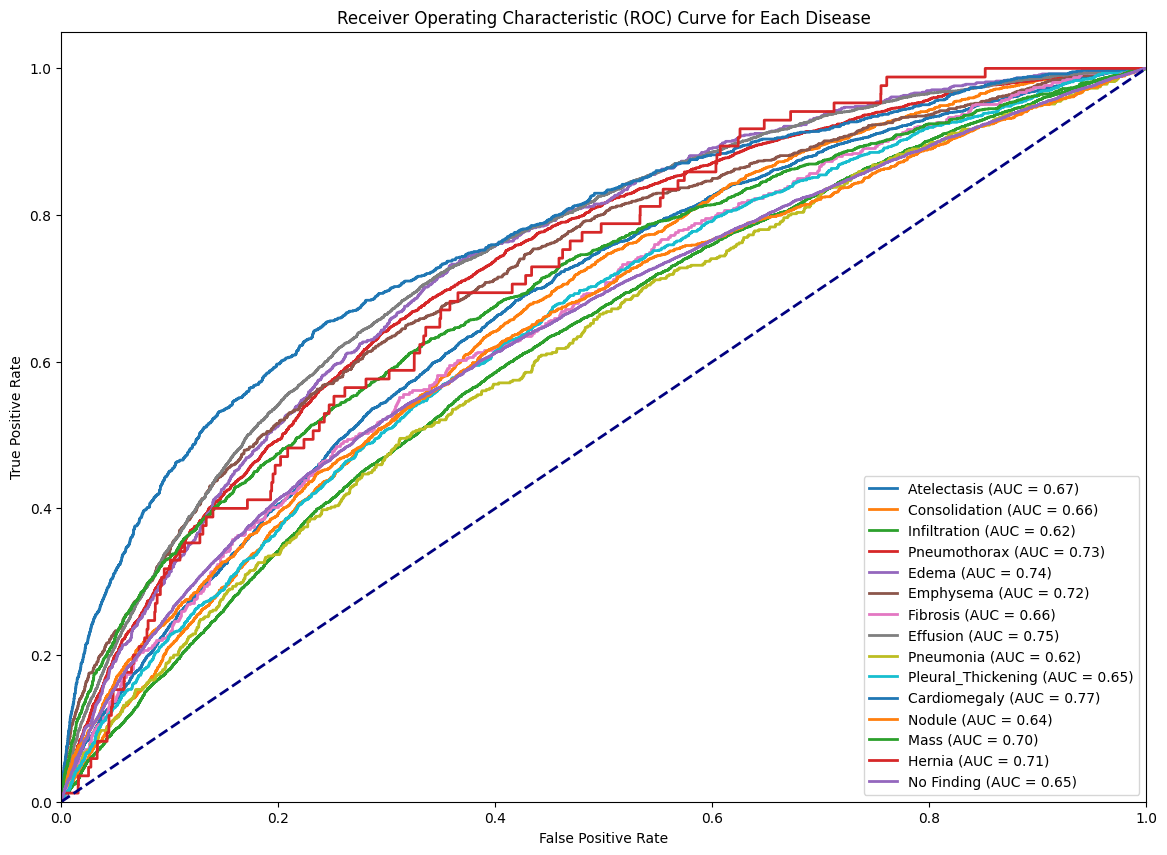

Atelectasis - ROC AUC Score: 0.6744
Consolidation - ROC AUC Score: 0.6638
Infiltration - ROC AUC Score: 0.6222
Pneumothorax - ROC AUC Score: 0.7291
Edema - ROC AUC Score: 0.7388
Emphysema - ROC AUC Score: 0.7238
Fibrosis - ROC AUC Score: 0.6596
Effusion - ROC AUC Score: 0.7458
Pneumonia - ROC AUC Score: 0.6174
Pleural_Thickening - ROC AUC Score: 0.6479
Cardiomegaly - ROC AUC Score: 0.7664
Nodule - ROC AUC Score: 0.6449
Mass - ROC AUC Score: 0.6962
Hernia - ROC AUC Score: 0.7145
No Finding - ROC AUC Score: 0.6469
Overall Accuracy: 0.7786


In [14]:
from sklearn.metrics import roc_auc_score, roc_curve, auc


# Plot ROC curve for each class
plt.figure(figsize=(14, 10))
for i, disease in enumerate(disease_labels):
    fpr, tpr, _ = roc_curve(all_labels[:, i], all_outputs[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f'{disease} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Disease')
plt.legend(loc='lower right')
plt.show()

# Print ROC AUC scores for each class
for i, disease in enumerate(disease_labels):
    roc_auc_label = roc_auc_score(all_labels[:, i], all_outputs[:, i])
    print(f'{disease} - ROC AUC Score: {roc_auc_label:.4f}')
    
# Calculate overall accuracy
overall_accuracy = roc_auc_score(all_labels.reshape(-1), all_outputs.reshape(-1))
print(f'Overall Accuracy: {overall_accuracy:.4f}')    


## 개별 스코어 값

In [15]:
# 정확도 및 F1 스코어 계산
accuracy = accuracy_score(all_labels, binary_outputs)
f1_micro = f1_score(all_labels, binary_outputs, average='micro')
f1_macro = f1_score(all_labels, binary_outputs, average='macro')

for idx in range(all_labels.shape[1]):
    accuracy_label = accuracy_score(all_labels[:, idx], binary_outputs[:, idx])
    f1_score_label = f1_score(all_labels[:, idx], binary_outputs[:, idx])
    print(f"Class {idx} - Accuracy: {accuracy_label}, F1 score: {f1_score_label}")

Class 0 - Accuracy: 0.796210197304161, F1 score: 0.26905829596412556
Class 1 - Accuracy: 0.9252588396171127, F1 score: 0.02547121752419766
Class 2 - Accuracy: 0.6913068958781012, F1 score: 0.3446960272041138
Class 3 - Accuracy: 0.8934166829458878, F1 score: 0.07147719537100068
Class 4 - Accuracy: 0.9615159210783356, F1 score: 0.046466602129719266
Class 5 - Accuracy: 0.9565930845868333, F1 score: 0.060862214708368556
Class 6 - Accuracy: 0.9826137917562023, F1 score: 0.0
Class 7 - Accuracy: 0.7778863059191248, F1 score: 0.42708858208203165
Class 8 - Accuracy: 0.9783551474897441, F1 score: 0.0035971223021582736
Class 9 - Accuracy: 0.9512014065247119, F1 score: 0.023455824863174355
Class 10 - Accuracy: 0.9478804453994921, F1 score: 0.23421354764638347
Class 11 - Accuracy: 0.9342449697206485, F1 score: 0.05714285714285714
Class 12 - Accuracy: 0.9065833170541121, F1 score: 0.22646392753154318
Class 13 - Accuracy: 0.9966790388747803, F1 score: 0.0
Class 14 - Accuracy: 0.6480562609884744, F1 s

# 각 loss 계산 결과

In [16]:
all_labels, all_outputs
# Cell 1: Import necessary libraries
import numpy as np
import torch
from sklearn.metrics import accuracy_score, f1_score, hamming_loss, coverage_error, label_ranking_loss, average_precision_score

# Assuming 'all_labels' and 'ensemble_preds' are already defined and have compatible shapes
# Convert ensemble probabilities to class predictions using a threshold (e.g., 0.5)
threshold = 0.5
all_outputs_pred = binary_outputs

# Define the disease labels
disease_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'No Finding']

# Calculate accuracy for each class
print("Accuracy for each class:")
for i, disease in enumerate(disease_labels):
    accuracy_class = accuracy_score(all_labels[:, i], all_outputs_pred[:, i])
    print(f'{disease} - Accuracy: {accuracy_class:.4f}')

# Calculate overall accuracy
overall_accuracy = accuracy_score(all_labels.reshape(-1), all_outputs_pred.reshape(-1))
print(f'Overall Accuracy: {overall_accuracy:.4f}')

print("all_labels.shape : ", all_labels.shape)

# Calculate overall accuracy before reshape
overall_accuracy_bf_reshape = accuracy_score(all_labels, all_outputs_pred)
print(f'Overall Accuracy before reshape: {overall_accuracy_bf_reshape:.4f}')


Accuracy for each class:
Atelectasis - Accuracy: 0.7962
Consolidation - Accuracy: 0.9253
Infiltration - Accuracy: 0.6913
Pneumothorax - Accuracy: 0.8934
Edema - Accuracy: 0.9615
Emphysema - Accuracy: 0.9566
Fibrosis - Accuracy: 0.9826
Effusion - Accuracy: 0.7779
Pneumonia - Accuracy: 0.9784
Pleural_Thickening - Accuracy: 0.9512
Cardiomegaly - Accuracy: 0.9479
Nodule - Accuracy: 0.9342
Mass - Accuracy: 0.9066
Hernia - Accuracy: 0.9967
No Finding - Accuracy: 0.6481
Overall Accuracy: 0.8899
all_labels.shape :  (25595, 15)
Overall Accuracy before reshape: 0.2170


In [17]:
# Cell 2: Calculate Hamming Loss
hamming_loss_value = hamming_loss(all_labels, all_outputs_pred)
print(f'Hamming Loss: {hamming_loss_value:.4f}')


Hamming Loss: 0.1101


In [18]:
# Cell 3: Calculate Ranking Loss
ranking_loss_value = label_ranking_loss(all_labels, all_outputs_pred)
print(f'Ranking Loss: {ranking_loss_value:.4f}')


Ranking Loss: 0.6981


In [19]:
from sklearn.metrics import jaccard_score
import numpy as np

def multilabel_accuracy(y_true, y_pred):
    """
    다중 레이블 정확도를 계산합니다.

    :param y_true: 실제 레이블 (2D numpy 배열 또는 리스트)
    :param y_pred: 예측된 레이블 (2D numpy 배열 또는 리스트)
    :return: 다중 레이블 정확도 (Jaccard Index의 평균)
    """
    # average='samples' 옵션은 각 샘플에 대한 Jaccard Index를 계산한 후 평균을 냅니다.
    return jaccard_score(y_true, y_pred, average='samples')

# # Cell 4: Calculate Multilabel Accuracy
multilabel_accuracy_score = multilabel_accuracy(all_labels, all_outputs_pred)
print(f'Multilabel Accuracy: {multilabel_accuracy_score:.4f}')

In [20]:
# # Cell 4: Calculate Multilabel Accuracy
multilabel_accuracy_score = multilabel_accuracy(all_labels, all_outputs_pred)
print(f'Multilabel Accuracy: {multilabel_accuracy_score:.4f}')

Multilabel Accuracy: 0.2821


In [21]:
# Cell 5: Calculate Multilabel Coverage
multilabel_coverage = coverage_error(all_labels, all_outputs_pred)
print(f'Multilabel Coverage: {multilabel_coverage:.4f}')


Multilabel Coverage: 11.5040


In [22]:
# Cell 6: Calculate One Error
def one_error(y_true, y_pred):
    n_samples = y_true.shape[0]
    one_error_count = 0
    for i in range(n_samples):
        top_pred_idx = np.argmax(y_pred[i])
        if y_true[i, top_pred_idx] == 0:
            one_error_count += 1
    return one_error_count / n_samples

one_error_value = one_error(all_labels, all_outputs_pred)
print(f'One Error: {one_error_value:.4f}')

One Error: 0.6446


In [23]:
# Cell 7: Calculate Subset Accuracy
subset_accuracy = accuracy_score(all_labels, all_outputs_pred, normalize=True)
print(f'Subset Accuracy: {subset_accuracy:.4f}')


Subset Accuracy: 0.2170


In [24]:
# Cell 8: Calculate Macro F1 Score
macro_f1_score = f1_score(all_labels, all_outputs_pred, average='macro')
print(f'Macro F1 Score: {macro_f1_score:.4f}')


Macro F1 Score: 0.1519


In [25]:
# Cell 9: Calculate Micro F1 Score
micro_f1_score = f1_score(all_labels, all_outputs_pred, average='micro')
print(f'Micro F1 Score: {micro_f1_score:.4f}')


Micro F1 Score: 0.3272


In [27]:
# Record each class accuracy
accuracy_each_class = []

# Calculate accuracy for each class
for i, disease in enumerate(disease_labels):
    accuracy_each_class.append(accuracy_score(all_labels[:, i], all_outputs_pred[:, i]))

columns = disease_labels

for i,v in enumerate(accuracy_each_class):
    accuracy_each_class[i] = f"{v:.4f}"

result = pd.DataFrame([accuracy_each_class], columns=columns)
result.to_csv("each_class_accuracy.csv", index=False)

In [28]:
# Record over all loss
columns = [
    "Hamming Loss",
    "Ranking Loss",
    "Multilabel Accuracy",
    "Multilabel Coverage",
    "One Error",
    "Subset Accuracy",
    "Macro F1 score",
    "Micro F1 score"
]

over_score=[]

over_score.append(f"{hamming_loss_value:.4f}")
over_score.append(f"{ranking_loss_value:.4f}")
over_score.append(f"{multilabel_accuracy_score:.4f}")
over_score.append(f"{multilabel_coverage:.4f}")
over_score.append(f"{one_error_value:.4f}")
over_score.append(f"{subset_accuracy:.4f}")
over_score.append(f"{macro_f1_score:.4f}")
over_score.append(f"{micro_f1_score:.4f}")

result = pd.DataFrame([over_score], columns=columns)
result.to_csv("overall_score.csv", index=False)

## 스코어

In [29]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..', 'utils')))

import pandas as pd
import calculate_metric as cm

preds = torch.from_numpy(all_outputs)
targets = torch.from_numpy(all_labels)

if not os.path.exists('results'):
    os.makedirs('results')

metrics = ['hamming_loss', 'ranking_loss', 'multilabel_coverage', 'one_error', 'subset_accuracy', 'macro_f1_score', 'micro_f1_score']
excel_writer = pd.ExcelWriter('results/scores_k.xlsx', engine='xlsxwriter')

df = test_df.loc[:, ['Image_Index', 'Finding_Labels', 'Paths']]

for metric in metrics:
    res_df = cm.results_low_score_image(df, predicts=preds, targets=targets, metric=metric)
    print(metric.replace('_', ' '))
    res_df.to_excel(excel_writer, sheet_name=metric.replace('_', ' '), index=False)

excel_writer.close()
print('Results saved to results/scores_k.xlsx')

hamming loss
ranking loss
multilabel coverage
one error
subset accuracy
macro f1 score
micro f1 score
Results saved to results/scores_k.xlsx


In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

# 예제 데이터
y_true = np.array([[1, 0, 1], [0, 1, 0], [1, 1, 0]])
y_pred = np.array([[1, 0, 0], [0, 1, 1], [1, 0, 1]])

# 다중 레이블 정확도 계산 (Strict match)
accuracy = accuracy_score(y_true, y_pred)
print(f"Strict Accuracy: {accuracy:.4f}")

Strict Accuracy: 0.0000


In [ ]:
from sklearn.metrics import jaccard_score
import numpy as np

def multilabel_accuracy(y_true, y_pred):
    """
    다중 레이블 정확도를 계산합니다.

    :param y_true: 실제 레이블 (2D numpy 배열 또는 리스트)
    :param y_pred: 예측된 레이블 (2D numpy 배열 또는 리스트)
    :return: 다중 레이블 정확도 (Jaccard Index의 평균)
    """
    # average='samples' 옵션은 각 샘플에 대한 Jaccard Index를 계산한 후 평균을 냅니다.
    return jaccard_score(y_true, y_pred, average='samples')

# 예제 데이터
y_true = np.array([[1, 0, 1], [0, 1, 0], [1, 1, 0]])
y_pred = np.array([[1, 0, 0], [0, 1, 1], [1, 0, 1]])

# 다중 레이블 정확도 계산
accuracy = multilabel_accuracy(y_true, y_pred)
print(f"Multilabel Accuracy: {accuracy:.4f}")

Multilabel Accuracy: 0.4444
